In [104]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


In [105]:
df_fema = pd.read_csv("FEMA.csv")
display(df_fema.head())
print("size: ", len(df_fema))

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,helperState,fipsCountyCode,helperCounty,fipscode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T04:00:00.000Z,1953,Tornado,TORNADO,0,1,...,13,0,0,13000,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15T04:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,...,48,0,0,48000,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06T04:00:00.000Z,1953,Flood,FLOODS,0,1,...,30,0,0,30000,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11T04:00:00.000Z,1953,Tornado,TORNADO,0,1,...,25,0,0,25000,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11T04:00:00.000Z,1953,Flood,FLOOD,0,1,...,19,0,0,19000,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


size:  60223


In [106]:
flood_num = len(df_fema[df_fema["incidentType"] == "Flood"])
flood_perc = flood_num/len(df_fema)

print("percentage of incidents that are floods: ", flood_perc * 100)

percentage of incidents that are floods:  17.24922371851286


In [107]:
df_weather = pd.read_csv("all_zip_codes.csv")
df_weather["date"] = pd.to_datetime(df_weather.date).dt.date
display(df_weather.head())
print("size: ", len(df_weather))

,date,zipcode,zip,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0
1,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0
2,1950-01-03,601,601,0.0,0.0,0.0,211.0,133.0,183.0
3,1950-01-04,601,601,0.0,0.0,0.0,200.0,144.0,167.0
4,1950-01-05,601,601,0.0,0.0,0.0,217.0,139.0,167.0


size:  10062209


In [108]:
df_zip_fips = pd.read_csv("ZIP-COUNTY-FIPS_2017-06.csv")
df_zip_fips.head()


,ZIP,COUNTYNAME,STATE,FIPS code
0,36003,Autauga County,AL,1001
1,36006,Autauga County,AL,1001
2,36067,Autauga County,AL,1001
3,36066,Autauga County,AL,1001
4,36703,Autauga County,AL,1001


In [109]:
#Merge the zip/fips data with the weather data in order to associate fips to zips for the weather
#in each zip code

df_weather_zip_fips = df_weather.merge(df_zip_fips, how="left", left_on="zipcode", right_on='ZIP')
display(df_weather_zip_fips.head())
print(len(df_weather_zip_fips))

,date,zipcode,zip,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,ZIP,COUNTYNAME,STATE,FIPS code
0,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Adjuntas Municipio,PR,72001
1,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Ponce Municipio,PR,72113
2,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Adjuntas Municipio,PR,72001
3,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Ponce Municipio,PR,72113
4,1950-01-03,601,601,0.0,0.0,0.0,211.0,133.0,183.0,601,Adjuntas Municipio,PR,72001


14789635


In [111]:
#Convert the incidentBegindate and incidentEndDate strings to datetime objects

df_fema["incidentBeginDate"] = pd.to_datetime(df_fema.incidentBeginDate).dt.date
df_fema["incidentEndDate"] = pd.to_datetime(df_fema.incidentEndDate).dt.date
#df_fema = df_fema[["fipscode", "incidentBeginDate", "incidentType"]]

display(df_fema.head())


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,helperState,fipsCountyCode,helperCounty,fipscode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T04:00:00.000Z,1953,Tornado,TORNADO,0,1,...,13,0,0,13000,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15T04:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,...,48,0,0,48000,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06T04:00:00.000Z,1953,Flood,FLOODS,0,1,...,30,0,0,30000,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11T04:00:00.000Z,1953,Tornado,TORNADO,0,1,...,25,0,0,25000,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11T04:00:00.000Z,1953,Flood,FLOOD,0,1,...,19,0,0,19000,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [112]:
flood = df_fema[['fipscode', 'incidentBeginDate', 'incidentEndDate', 'incidentType']][df_fema['incidentType'] == "Flood"]
display(flood.head())

,fipscode,incidentBeginDate,incidentEndDate,incidentType
2,30000,1953-06-06,1953-06-06,Flood
4,19000,1953-06-11,1953-06-11,Flood
5,48000,1953-06-19,1953-06-19,Flood
6,22000,1953-05-29,1953-05-29,Flood
10,12000,1953-10-22,1953-10-22,Flood


In [8]:
display(flood[flood['incidentBeginDate'] != flood['incidentEndDate']].head())
print(len(flood))

,fipscode,incidentBeginDate,incidentEndDate,incidentType
4974,25001,1978-02-06,1978-02-08,Flood
4975,25007,1978-02-06,1978-02-08,Flood
4976,25005,1978-02-06,1978-02-08,Flood
4977,25009,1978-02-06,1978-02-08,Flood
4979,25019,1978-02-06,1978-02-08,Flood


10388


In [163]:
#create dataframe with fipscode    
flood_dates = []
for i in flood.iterrows():
    if i[1]['incidentBeginDate'] == i[1]['incidentEndDate']:
        flood_dates.append([i[1]['fipscode'], i[1]['incidentBeginDate'], i[1]['incidentType']])

    else:
        date_range = list(pd.date_range(start=i[1]['incidentBeginDate'],end=i[1]['incidentEndDate']))
        for d in date_range:
            flood_dates.append([i[1]['fipscode'], str(d)[:10], i[1]['incidentType']])
          
display(flood_dates[:5])

[[30000, datetime.date(1953, 6, 6), 'Flood'],
 [19000, datetime.date(1953, 6, 11), 'Flood'],
 [48000, datetime.date(1953, 6, 19), 'Flood'],
 [22000, datetime.date(1953, 5, 29), 'Flood'],
 [12000, datetime.date(1953, 10, 22), 'Flood']]

In [172]:
df_flood_dates = pd.DataFrame(flood_dates, columns=['fipscode', 'date', 'flood'])
display(df_flood_dates.head())


,fipscode,date,flood
0,30000,1953-06-06,Flood
1,19000,1953-06-11,Flood
2,48000,1953-06-19,Flood
3,22000,1953-05-29,Flood
4,12000,1953-10-22,Flood


In [173]:
df_flood_dates['date'] = df_flood_dates.date.astype('str')
df_flood_dates['date'] = pd.to_datetime(df_flood_dates.date, errors='coerce').dt.date


In [175]:
display(df_flood_dates.head())
display(df_weather_zip_fips.head())
print(len(df_flood_dates[df_flood_dates['flood'] == 'Flood']))
print(df_weather_zip_fips.dtypes)
print(df_flood_dates.dtypes)

,fipscode,date,flood
0,30000,1953-06-06,Flood
1,19000,1953-06-11,Flood
2,48000,1953-06-19,Flood
3,22000,1953-05-29,Flood
4,12000,1953-10-22,Flood


,date,zipcode,zip,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,ZIP,COUNTYNAME,STATE,FIPS code
0,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Adjuntas Municipio,PR,72001
1,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Ponce Municipio,PR,72113
2,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Adjuntas Municipio,PR,72001
3,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Ponce Municipio,PR,72113
4,1950-01-03,601,601,0.0,0.0,0.0,211.0,133.0,183.0,601,Adjuntas Municipio,PR,72001


276994
date           object
zipcode         int64
zip             int64
PRCP          float64
SNOW          float64
SNWD          float64
TMAX          float64
TMIN          float64
TOBS          float64
ZIP             int64
COUNTYNAME     object
STATE          object
FIPS code       int64
dtype: object
fipscode     int64
date        object
flood       object
dtype: object


In [176]:
#Create final dataset by merging the weather data with 
df_final = df_weather_zip_fips.merge(df_flood_dates, how='left', left_on=["FIPS code", "date"], right_on=["fipscode","date"])
display(df_final.head())


,date,zipcode,zip,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,ZIP,COUNTYNAME,STATE,FIPS code,fipscode,flood
0,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Adjuntas Municipio,PR,72001,NaN,NaN
1,1950-01-01,601,601,18.0,0.0,0.0,183.0,128.0,156.0,601,Ponce Municipio,PR,72113,NaN,NaN
2,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Adjuntas Municipio,PR,72001,NaN,NaN
3,1950-01-02,601,601,18.0,0.0,0.0,194.0,122.0,167.0,601,Ponce Municipio,PR,72113,NaN,NaN
4,1950-01-03,601,601,0.0,0.0,0.0,211.0,133.0,183.0,601,Adjuntas Municipio,PR,72001,NaN,NaN


In [177]:
print(len(df_final[df_final['flood'] == "Flood"]))
print(len(df_final))

49377
14792388


In [178]:
flood_num = len(df_final[df_final["flood"] == "Flood"])
flood_perc = flood_num/len(df_final)

print("percentage of incidents that are floods after merges: ", flood_perc * 100)
print("df_final record num:", len(df_final))

percentage of incidents that are floods after merges:  0.33380005986862976
df_final record num: 14792388


In [179]:
X = df_final[["PRCP", "SNOW", "SNWD","TMAX", "TMIN", "TOBS"]]

min_max_scaler = MinMaxScaler()
#X[["PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "TOBS"]] = min_max_scaler.fit_transform(
#                                                X[["PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "TOBS"]])

df_final['flood'] = df_final['flood'].apply(lambda x: 1 if x == 'Flood' else 0)
#df_final['flood'] = df_final['flood'].fillna(0)
#y.loc[y["incidentType"] == "Flood"] = 1
#y.loc[y["incidentType"] != 1] = 0
y = df_final['flood']

#print("number of records in X with NaN: ", X.isna().sum())
#print("number of records in y with NaN: ", y["incidentType"].isna().sum())

print(len(X))
print(len(y))

14792388
14792388


In [180]:
display(df_final['flood'])
print('Number of positive labels: ', len(y[y == 1]))
print('Number of negative labels: ', len(y[y  == 0]))
print('Total number of labels: ', len(y))

0           0
1           0
2           0
3           0
4           0
           ..
14792383    0
14792384    0
14792385    0
14792386    0
14792387    0
Name: flood, Length: 14792388, dtype: int64

Number of positive labels:  49377
Number of negative labels:  14743011
Total number of labels:  14792388


In [181]:
#Create training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 27)

display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())

print("X record num:", len(X))
print("x_train record num: ", len(X_train))
print("y_train record num: ", len(y_train))
print("x_test record num: ", len(X_test))
print("y_test record num: ", len(y_test))

print("number of 1 values in y_train: ", len(y_train[y_train == 1]))
print("number of 0 values in y_train: ", len(y_train[y_train == 0]))
print("number of 1 values in y_test: ", len(y_test[y_test == 1]))
print("number of 0 values in y_test: ", len(y_test[y_test == 0]))

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
608676,0.0,0.0,127.0,17.0,-156.0,-156.0
10808825,114.0,0.0,0.0,267.0,150.0,178.0
2582280,0.0,0.0,0.0,94.0,-22.0,89.0
4464847,61.0,0.0,0.0,172.0,100.0,128.0
6516483,381.0,0.0,0.0,156.0,39.0,72.0


608676      0
10808825    0
2582280     0
4464847     0
6516483     0
Name: flood, dtype: int64

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
13559226,0.0,0.0,0.0,206.0,-22.0,-6.0
1808594,0.0,0.0,0.0,267.0,100.0,122.0
8683378,0.0,0.0,0.0,311.0,156.0,239.0
6036859,0.0,0.0,0.0,67.0,-50.0,-22.0
11481667,0.0,0.0,0.0,-56.0,-150.0,-150.0


13559226    0
1808594     0
8683378     0
6036859     0
11481667    0
Name: flood, dtype: int64

X record num: 14792388
x_train record num:  11094291
y_train record num:  11094291
x_test record num:  3698097
y_test record num:  3698097
number of 1 values in y_train:  37032
number of 0 values in y_train:  11057259
number of 1 values in y_test:  12345
number of 0 values in y_test:  3685752


In [182]:
########## Downsample data ############

#Scale training and test data

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

mask = y_train.apply(lambda x: x > 0 or random.random() > 0.99)

#temp = pd.DataFrame([random.random() for _ in range(len(y_train))], columns=['random'])
#temp['incidentType'] = y_train
#print('number of nans: ', len(y_train[(y_train['incidentType'] != 0) & (y_train['incidentType'] != 1)]))

#display(temp[(temp['incidentType'] > 0) | (temp['random'] >.99)])
#mask2 = (temp['incidentType'] > 0) | (temp['random'] >.99)
#display(mask2)

X_train_bal = X_train_scaled[mask]
y_train_bal = y_train[mask]


print('X_Train_scaled record count: ', len(X_train_scaled))
print('X_train_bal record count: ', len(X_train_bal))
print('number of 1 values in y_train: ', len(y_train[y_train == 1])) 
print('number of 1 values in y_train_bal: ', len(y_train_bal[y_train_bal ==1])) 
print('number of 0 values in y_train: ', len(y_train[y_train ==0])) 
print('number of 0 values in y_train_bal: ', len(y_train_bal[y_train_bal ==0])) 
 
#print("number of records in X with NaN: ", X.isna().sum())
#print("number of records in y with NaN: ", y["incidentType"].isna().sum())

X_Train_scaled record count:  11094291
X_train_bal record count:  147421
number of 1 values in y_train:  37032
number of 1 values in y_train_bal:  37032
number of 0 values in y_train:  11057259
number of 0 values in y_train_bal:  110389


C:\Users\Mo-B\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[3649531   36221]
 [  11594     751]]
accuracy_score:  0.9870703770074176


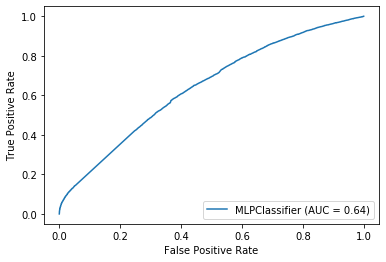

In [184]:
clf = MLPClassifier(solver='lbfgs', alpha = 1e-5, hidden_layer_sizes = (5,2), random_state=1)
#clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=0.0001,
#                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

clf.fit(X_train_bal, y_train_bal)

predictions_mlp = clf.predict(X_test_scaled)

print(confusion_matrix(y_test, predictions_mlp))
print("accuracy_score: ", accuracy_score(y_test, predictions_mlp))
      
plot_roc_curve(clf, X_test_scaled, y_test)      
plt.show()
      

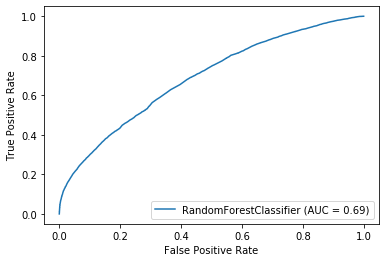

In [185]:
#rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf = RandomForestClassifier(max_depth = 10, n_estimators = 10, random_state = 0)

rf.fit(X_train_bal, y_train_bal)

plot_roc_curve(rf, X_test_scaled, y_test)      
plt.show()

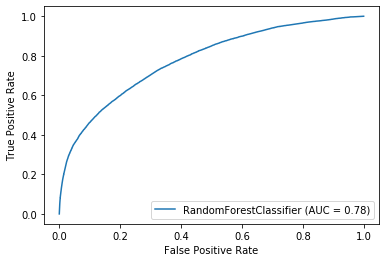

In [186]:
rf2 = RandomForestClassifier(max_depth = 25, n_estimators = 25, criterion = 'entropy', random_state = 0)

rf2.fit(X_train_bal, y_train_bal)

plot_roc_curve(rf2, X_test_scaled, y_test)      
plt.show()

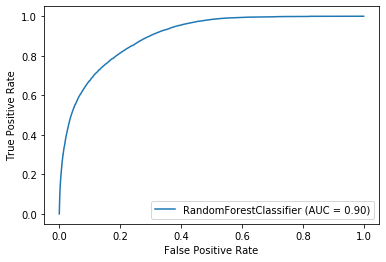

In [187]:
plot_roc_curve(rf2, X_train_scaled, y_train)  
plt.show()

In [188]:
predictions_rf2 = rf2.predict(X_test_scaled)

print(confusion_matrix(y_test, predictions_rf2))
print('accuracy score: ', accuracy_score(y_test, predictions_rf2))

proba2 = rf2.predict_proba(X_test_scaled)[:,1]
print('roc_auc_score: ', roc_auc_score(y_test, proba2))


[[3513841  171911]
 [   8031    4314]]
accuracy score:  0.9513420010345862
roc_auc_score:  0.7803997329469557


In [54]:
df_weather_predictions = pd.read_csv("NOAA_weather_forecast_predictions.csv")

In [62]:
df_weather_pred_scaled = scaler.transform(df_weather_predictions[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']])

In [63]:
display(df_weather_pred_scaled[:5])

array([[ 0.15935306,  0.26129266, -0.14797948, -0.16327729,  0.07503338,
        -0.1331554 ],
       [ 0.18824129,  0.32894595, -0.21376418, -0.14744711,  0.10349881,
        -0.14252976],
       [ 0.21719351,  0.39674735, -0.27953499, -0.13161284,  0.13198025,
        -0.15193037],
       [ 0.24622465,  0.46461125, -0.34533069, -0.11579552,  0.16047685,
        -0.16139182],
       [ 0.27504788,  0.53228531, -0.41114962, -0.09991535,  0.18895744,
        -0.17076614]])

In [64]:
df_weather_predictions['Flood'] = rf2.predict_proba(df_weather_pred_scaled)[:, 1]

In [66]:
display(df_weather_predictions.head())

,zipcode,year,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,Flood
0,16601,2030,36.704178,6.832971,5.034125,155.709286,57.087498,79.935546,0.41
1,16601,2040,38.987804,8.066879,-0.581523,157.545249,60.140693,78.845724,0.44
2,16601,2050,41.276487,9.303487,-6.195984,159.381684,63.195606,77.752849,0.41
3,16601,2060,43.571408,10.541236,-11.812570,161.216156,66.252145,76.652903,0.30
4,16601,2070,45.849895,11.775522,-17.431140,163.057915,69.306966,75.563086,0.26


In [73]:
df_weather_predictions.to_csv('flood_prediction_using_NOAA_weather_forecast_predictions.csv', index=False)